<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/MARCA-Color.jpg" title="Title text" width="50%" height="50%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales II-2018 </h1>

<H3 align='center'> Tarea 3 - Redes Recurrentes y Autoencoders </H3>
<hr style="height:2px;border:none"/>

<H4 align='center'> Camilo Maldonado - 201573013-k </H4>
<H4 align='center'> Diego Córdova - 201403009-6 </H4>

<a id="segundo"></a>
# 2. Autoencoders (AEs) en MNIST


# Como se ha discutido en clases, las RBM’s y posteriormente los AE’s (redes no supervisadas) fueron un componente crucial en el desarrollo de los modelos que entre 2006 y 2010 vigorizaron el área de las redes neuronales artificiales con logros notables de desempeño en diferentes tareas de aprendizaje automático. En esta sección aprenderemos a utilizar el más sencillo de estos modelos: un autoencoder o AE. Consideraremos tres aplicaciones clásicas: reducción de dimensionalidad, *denoising* y pre-entrenamiento. Con este objetivo en mente, utilizaremos un dataset denominado MNIST[[3]](#refs). Se trata de una colección de 70000 imágenes de 28 $\times$ 28 pixeles correspondientes a dígitos manuscritos (números entre 0 y 9). En su versión tradicional, la colección se encuentra separada en dos subconjuntos: uno de entrenamiento de 60000 imágenes y otro de test de 10000 imágenes. La tarea consiste en construir un programa para que aprenda a identificar correctamente el dı́gito representado en la imagen
# New Section

> a) Escriba el código que **cargue los datos** desde el repositorio de keras, normalice las imágenes de modo que los pixeles queden en [0, 1], transforme las imágenes en vectores ($\in {\rm I\!R}^{784}$) y devuelva tres subconjuntos disjuntos: uno de entrenamiento, uno de validación y uno de pruebas. Construya el conjunto de validación de la manera que estime conveniente, éste debe contar con $nval = 5000$ imágenes.
```python
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255. #and x_test
...#Define here your validation set
```

### 2.1 Reducción de dimensionalidad
Para esta primera sección, gracias a la simplicidad del problema tratado, se experimentará con un autoencoder tradicional (*feed forward*) en donde las capas de éste sean densas. Para esto se re estructurarán los datos de entradas en forma de vector, es decir la matriz de 28 $\times$ 28 pasa a ser un vector de 784 componentes.

```python
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
...#other sets "x"
```

Una de las aplicaciones tı́picas de un AE es reducción de dimensionalidad, es decir, implementar una transformación $\phi:{\rm I\!R}^d \rightarrow {\rm I\!R}^{d'}$ de objetos representados originalmente por $d$ atributos en una nueva representación de $d'$ atributos, de modo tal que se preserve lo mejor posible la “información” original. Obtener tal representación es útil desde un punto de vista computacional (compresión) y estadı́stico (permite construir modelos con un menor número de parámetros libres). Un AE es una técnica de reducción de dimensionalidad no supervisada porque no hace uso de información acerca de las clases a las que pertenecen los datos de entrenamiento.  

> a) Entrene un AE básico (1 capa escondida) para generar una representación de MNIST en $d'$= 2, 8, 32, 64 dimensiones. **Justifique la elección de la función de pérdida a utilizar y del criterio de entrenamiento en general**. Determine el porcentaje de compresión obtenido y el error de reconstrucción en cada caso. **¿Mejora el resultado si elegimos una función de activación *ReLU* para el *Encoder*? ¿Podrı́a y/o corresponde utilizar ésta activación en el *Decoder*?**
```python
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
input_img = Input(shape=(784,))
encoded = Dense(32, activation='sigmoid')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input=input_img, output=decoded)
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,validation_data=(x_val,x_val))
autoencoder.save('basic_autoencoder_768x32.h5')
...#save other stuffs if you want
```

> b) Compare visualmente la reconstrucción que logra hacer el *autoencoder* desde la representación en ${\rm I\!R}^{d'}$ para algunas imágenes del conjunto de pruebas. **Determine si la percepción visual se corresponde con el error de reconstrucción observada**. Comente.
```python
from keras.models import load_model
autoencoder = load_model('basic_autoencoder_768x32.h5')
...#load other stuff
encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    j = np.random.randint(0,len(x_test))
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
```

> c) Para verificar la calidad de la representación obtenida, implemente el clasificador denominado $kNN$ (k-nearest neighbor): dada una imagen $x$, el clasificador busca las k = 10 imágenes de entrenamiento más similares (de acuerdo a una distancia, e.g. euclidiana) y predice como clase, la etiqueta más popular entre las imágenes cercanas. **Mida el error de pruebas** obtenido construyendo este clasificador sobre la data reducida a través del *autoencoder* comparando con la representación reducida obtenida vía PCA (una técnica clásica de reducción de dimensionalidad) utilizando el mismo número de dimensiones $d'$= 2, 4, 8, 16, 32. Considere tanto el error de reconstrucción como el desempeño en clasificación , además de comparar los tiempos medios de predicción en ambos escenarios **¿La representación generada por el *autoencoder* logra generalizar?**
```python
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
pca = PCA(n_components=d)
pca.fit(x_train)
pca_train = pca.transform(x_train)
pca_test = pca.transform(x_test)
...#AUTOENCODER
encoded_train = encoder.predict(x_train)
encoded_test = encoder.predict(x_test)
...#CLASIFICATION
clf = KNeighborsClassifier(10)
clf.fit(pca_train, y_train)
print 'Classification Accuracy PCA %.2f' % clf.score(pca_test,y_test)
clf = KNeighborsClassifier(10)
clf.fit(encoded_train, y_train)
print 'Classification Accuracy %.2f' % clf.score(encoded_test,y_test)
```

> d) Modifique el *autoencoder* básico construido en (a) para implementar un deep autoencoder (*deep AE*), es decir, un autoencoder con al menos dos capas ocultas. **Demuestre experimentalmente** que este *autoencoder* puede mejorar la compresión obtenida por PCA utilizando el mismo número de dimensiones $d'$ . Experimente con $d'$ =2, 4, 8, 16 y distintas profundidades ($L \in [2,4]$). Considere en esta comparación tanto el error de reconstrucción como el desempeño en clasificación (vı́a kNN) de cada representación. Comente.
```python
target_dim = 2 #try other and do a nice plot
input_img = Input(shape=(784,))
encoded1 = Dense(1000, activation='relu')(input_img)
encoded2 = Dense(500, activation='relu')(encoded1)
encoded3 = Dense(250, activation='relu')(encoded2)
encoded4 = Dense(target_dim, activation='relu')(encoded3)
decoded4 = Dense(250, activation='relu')(encoded4)
decoded3 = Dense(500, activation='relu')(encoded3)
decoded2 = Dense(1000, activation='relu')(decoded3)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
autoencoder = Model(input=input_img, output=decoded1)
encoder = Model(input=input_img, output=encoded3)
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,epochs=40,batch_size=32,validation_data=(x_val,x_val))
autoencoder.save('my_autoencoder_768x1000x500x250x2.h5')
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
pca = PCA(n_components=target_dim)
pca.fit(x_train)
```

> e) Elija algunas de las representaciones aprendidas anteriormente ($d>2$) y visualı́celas usando la herramienta *TSNE* disponible en la librerı́a *sklearn*. **Compare cualitativamente el resultado con aquel obtenido usando PCA** con el mismo número de componentes ($d>2$). Finalmente **grafique una representación** generada por un autoencoder directamente ($d=2$), comente.
```python
nplot=5000 #warning: mind your memory!
encoded_train = encoder.predict(x_train[:nplot])
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in xrange(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
pca_train = pca.transform(x_train)
encoded_train = pca_train[:nplot]
... #plot PCA
... #plot AE (d=2) without TSNE
encoded_train = encoder2d.predict(x_train[:nplot]) #Autoencoder with d=2
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in xrange(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
```

> f) Cuando el problema se torna más difícil es necesario complejizar el modelo. Modifique el autoencoder construido en (a) para trabajar directamente sobre las imágenes de MNIST, sin tratarlas como vectores de 784 atributos, sino como matrices de tamaño $1\times28\times28$. Es posible lograr este objetivo utilizando capas convolucionales para definir el *Encoder* y capas con **convoluciones transpuesta** en el *Decoder*, comente como sufre las transformaciones el patrón de entrada. Compare la calidad de la representación reducida obtenida por el nuevo autoencoder con aquella obtenida anteriormente utilizando el mismo número de dimensiones. Comente.
```python
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) #modify for th dim ordering
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
from keras.layers import *
input_img = Input(shape=(28, 28, 1))
x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()
```

### 2.2 Denoising
Como se ha discutido en clases, un *denoising autoencoder* (dAE)[[4]](#refs) es escencialmente un autoencoder entrenado para reconstruir ejemplos parcialmente corruptos. Varios autores han demostrado que mediante esta modificación simple es posible obtener representaciones más robustas y significativas que aquellas obtenidas por un AE básico. En esta sección exploraremos la aplicación más “natural” o “directa” del método.

> a) **Genere artificialmente una versión corrupta de las imágenes en MNIST** utilizando el siguiente modelo de ruido (masking noise): si $ x \in {\rm I\!R}^d $ es una de las imágenes originales, la versión ruidosa $\tilde{x}$ se obtiene como $\tilde{x} = x \odot \xi$ donde $\odot$ denota el producto de Hadamard (componente a componente) y $\xi \in {\rm I\!R}^d$ es un vector aleatorio binario con componentes *Ber(p)* independientes.
```python
from numpy.random import binomial
noise_level = 0.1
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
noisy_x_test = x_test*noise_mask
```

> b) Entrene un autoencoder para reconstruir las imágenes corruptas generadas en el ı́tem anterior. **Mida el error de reconstrucción y evalúe cualitativamente** (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes. **Experimente diferentes valores de *p* en el rango (0, 1).**
```python
...# DEFINE YOUR AUTOENCODER AS BEFORE
autoencoder.fit(noisy_x_train, x_train, epochs=40, batch_size=32, validation_data=(noisy_x_val, x_val))
```

> c) Utilice la representación reducida, genera por el *denoising AE*, para **medir el desempeño en clasificación** (vı́a kNN como en la sección anterior). Comente.

> d) Diseñe otra manera de generar imágenes corruptas del dataset MNIST, por ejemplo algún tipo de ruido, sea creativo. **Mida el error de reconstrucción y evalúe cualitativamente** (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes

### 2.3 *Similarity reconstruct*

En esta sección se explorará una forma diferente de implementar un *autoencoder* que es utilizar la arquitectura del *autoencoder* pero no para reconstruir el mismo dato, sino que para reconstruir un dato similar. En este caso la similaridad estará dada por las clases de los datos.

> a) Genere pares de objetos $(objeto,similar)$ con 10 datos similares al dato "objeto", para ésto utilice la función que se provee a continuación sobre los primeros (1000 a 2000) datos de entrenamiento. **Visualice los nuevos datos generados y la relación que se produce entre los pares de objetos**.
```python
def similarity_data(X,Y,sim=10):
    index_classes = [ np.where(Y==number)[0] for number in range(10)]
    new_X = np.zeros((1,X.shape[1]))
    simi_X = np.zeros((1,X.shape[1]))
    for x,y in zip(X,Y):
        similarities = index_classes[y]
        sample_sim = np.random.choice(similarities,sim)
        new_X = np.concatenate((new_X, np.tile(x,(sim,1))),axis=0)
        simi_X = np.concatenate((simi_X, X[sample_sim]),axis=0)
    return new_X[1:],simi_X[1:]
data, data_sim = similarity_data(x_train[:2000],y_train[:2000])
...#visualize data
```

> b) Escoga algunas de las arquitecturas ya experimentadas hasta este punto de la actividad y entrénela para enfrentarla a éste problema **¿La función de pérdida se mantiene?**
```python
autoencoder.fit(data,data_sim,epochs=50,batch_size=32,validation_split=0.2)
```

> c) **Visualice lo que genera el *autoencoder* dado una imagen de entrada**. Además **visualice, con la herramienta TSNE, los *embedding*/representación reducida** que se producen en el *encoder*.
```python
autoencoder.predict(data)
embeddings = encoder.predict(data) #project this with TSNE
```


### 2.4 Pre-*training*

En esta sección utilizaremos un AE para pre-entrenar redes profundas. Como hemos discutido en clases, el efecto esperado es regularizar el modelo, posicionando el modelo de partida en una buena zona del espacio de parámetros.

> a) Construya y entrene una red FF para clasificar las imágenes de MNIST. Utilice SGD básico con tasa de aprendizaje fija $\eta = 0.01$, momentum $m=0.9$ y no más de 50 *epochs*. Para empezar, utilice una arquitectura $768 \times 1000 \times 1000 \times 10$ y **funciones de activación sigmoidales**. **Determine error de clasificación alcanzado por el modelo en el conjunto de test.**
```python
from keras.utils import to_categorical
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)
from keras.models import Sequential
model = Sequential()
model.add(Dense(1000, activation='sigmoid', input_shape=(784,)))
model.add(Dense(1000, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))
model.summary()
optimizer_ = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train,nb_epoch=50, batch_size=25,shuffle=True, validation_data=(x_val, Y_val))
model.save('ReluNet-768x1000x1000x10-NFT-50epochs.h5')
```

> b) Construya y entrene una red neuronal profunda para clasificar las imágenes de MNIST utilizando la arquitectura propuesta en (a) y pre-entrenando los pesos de cada capa mediante un autoencoder básico. Proceda en modo clásico, es decir, entrenando en modo no supervisado una capa a la vez y tomando como input de cada nivel la representación (entrenada) obtenida en el nivel anterior. Después del entrenamiento efectúe un entrenamiento supervisado convencional (*fine-tunning*). **Compare los resultados de clasificación sobre el conjunto de pruebas con aquellos obtenidos en (a), sin pre-entrenamiento. Evalúe también los resultados antes del *fine-tunning*.** Comente.
```python
from keras.datasets import mnist
... ## Load and preprocess MNIST as usual
...###AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1,activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(inputs=input_img1, outputs=decoded1)
encoder1 = Model(inputs=input_img1, outputs=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(x_train, x_train, nb_epoch=epochs_, batch_size=batch_size_,shuffle=True, validation_data=(x_val, x_val))
encoded_input1 = Input(shape=(n_hidden_layer1,))
autoencoder1.save('autoencoder_layer1.h5')
encoder1.save('encoder_layer1.h5')
...###AUTOENCODER 2
x_train_encoded1 = encoder1.predict(x_train) #FORWARD PASS DATA THROUGH FIRST ENCODER
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)
input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer2, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(inputs=input_img2, outputs=decoded2)
encoder2 = Model(inputs=input_img2, outputs=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(x_train_encoded1,x_train_encoded1,nb_epoch=epochs_,batch_size=batch_size_,shuffle=True, validation_data=(x_val_encoded1, x_val_encoded1))
encoded_input2 = Input(shape=(n_hidden_layer2,))
autoencoder2.save('autoencoder_layer2.h5')
encoder2.save('encoder_layer2.h5')
...#FINE TUNNING
from keras.models import Sequential
model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.layers[-1].set_weights(autoencoder2.layers[1].get_weights())
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer=optimizer_,loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train,nb_epoch=20, batch_size=25,
shuffle=True, validation_data=(x_val, Y_val))
model.save('Net-768x1000x1000x10-finetunned.h5')
```

> c) Repita usando funciones de **activación *tanh*. Comente**

## Compresión a través de AE

### Cargamos la data
Además la normalizamos y separamos en conjunto de testing, validación y entrenamiento. Además transformamos la imagen 2D en un vector.

In [0]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Normalize data
x_train = x_train.astype('float32') / 255. 
x_test = x_test.astype('float32') / 255. 
x_val  = x_train[:5000]
y_val = x_train[:5000]
x_train = x_train[5000:]
y_train = y_train[5000:]
print(x_train.shape,x_val.shape,x_test.shape)
# Convert to vector
x_train = x_train.reshape((x_train.shape[0],x_train[0].size))
x_test = x_test.reshape((x_test.shape[0],x_test[0].size))
x_val = x_val.reshape((x_val.shape[0],x_val[0].size))
print(x_train.shape,x_val.shape,x_test.shape)

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step
(55000, 28, 28) (5000, 28, 28) (10000, 28, 28)
(55000, 784) (5000, 784) (10000, 784)


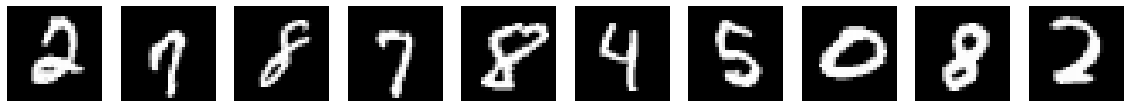

In [0]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    j = np.random.randint(0,len(x_test))
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
      
plt.show()

### Entrenamos AE para comprimir información
Primero lo trabajamos con una dimensión de 32 y probaremos la diferencia de usar sigmoide o relu como función de activación, porteriormente ocupamos la mejor función entre ambas para entrenar el AE para el resto de dimensiones.

#### AE (d=32, Sigmoid/ReLU)

In [0]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
input_img = Input(shape=(784,))
encoded = Dense(32, activation='sigmoid')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input=input_img, output=decoded)
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,validation_data=(x_val,x_val))
autoencoder.save('basic_autoencoder_768x32.h5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 7s 123us/step - loss: 0.3042 - val_loss: 0.2682
Epoch 2/50
55000/55000 [==============================] - 6s 111us/step - loss: 0.2664 - val_loss: 0.2652
Epoch 3/50
55000/55000 [==============================] - 6s 113us/step - loss: 0.2647 - val_loss: 0.2643
Epoch 4/50
55000/55000 [==============================] - 6s 112us/step - loss: 0.2639 - val_loss: 0.2631
Epoch 5/50
55000/55000 [==============================] - 7s 124us/step - loss: 0.2624 - val_loss: 0.2615
Epoch 6/50
55000/55000 [==============================] - 7s 125us/step - loss: 0.2606 - val_loss: 0.2597
Epoch 7/50
55000/55000 [==============================] - 6s 114us/step - loss: 0.2588 - val_loss: 0.2576
Epoch 8/50
55000/55000 [==============================] - 6s 114us/step - loss: 0.2567 - val_loss: 0.2556
Epoch 9/50
55000/55000 [==============================] - 6s 114us/step - loss: 0.2548 - val_loss: 0.25

In [0]:
input_img = Input(shape=(784,))
encoded = Dense(32, activation='relu')(input_img)
decoded = Dense(784, activation='relu')(encoded)
autoencoder = Model(input=input_img, output=decoded)
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,validation_data=(x_val,x_val))
autoencoder.save('basic_autoencoder_768x32(ReLU).h5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """


Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 7s 125us/step - loss: 2.8909 - val_loss: 3.1034
Epoch 2/50
55000/55000 [==============================] - 7s 127us/step - loss: 3.1012 - val_loss: 3.1034
Epoch 3/50
55000/55000 [==============================] - 6s 111us/step - loss: 3.1012 - val_loss: 3.1034
Epoch 4/50
55000/55000 [==============================] - 6s 111us/step - loss: 3.1012 - val_loss: 3.1034
Epoch 5/50
55000/55000 [==============================] - 6s 111us/step - loss: 3.1012 - val_loss: 3.1034
Epoch 6/50
55000/55000 [==============================] - 6s 111us/step - loss: 3.1012 - val_loss: 3.1034
Epoch 7/50
55000/55000 [==============================] - 6s 112us/step - loss: 3.1012 - val_loss: 3.1034
Epoch 8/50
55000/55000 [==============================] - 6s 113us/step - loss: 3.1012 - val_loss: 3.1034
Epoch 9/50
55000/55000 [==============================] - 6s 112us/step - loss: 3.1012 - val_loss: 3.10

In [0]:
import keras
# Sigmoid function
path = 'basic_autoencoder_768x32.h5'
model = keras.models.load_model(path)
score = model.evaluate(x_test, x_test, verbose=0)
print('Sigmoid')
print(model.metrics_names)
print(score)


# ReLU function
path = 'basic_autoencoder_768x32(ReLU).h5'
model = keras.models.load_model(path)
score = model.evaluate(x_test, x_test, verbose=0)
print('ReLU')
print(model.metrics_names)
print(score)

Sigmoid
['loss']
0.19428888883590698
ReLU
['loss']
3.0923462463378906


#### AE con distintas dimensiones de compresión

In [0]:
dimensions = [2,8,32,64]
for d in dimensions:
  input_img = Input(shape=(784,))
  encoded = Dense(d, activation='sigmoid')(input_img)
  decoded = Dense(784, activation='sigmoid')(encoded)
  autoencoder = Model(input=input_img, output=decoded)
  encoder = Model(input=input_img, output=encoded)
  encoded_input = Input(shape=(d,))
  decoder_layer = autoencoder.layers[-1]
  decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
  autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
  autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,validation_data=(x_val,x_val))
  autoencoder.save('basic_autoencoder_768x'+str(d)+'.h5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 7s 130us/step - loss: 0.4548 - val_loss: 0.3473
Epoch 2/50
55000/55000 [==============================] - 7s 119us/step - loss: 0.3194 - val_loss: 0.3016
Epoch 3/50
55000/55000 [==============================] - 7s 120us/step - loss: 0.2932 - val_loss: 0.2868
Epoch 4/50
55000/55000 [==============================] - 6s 115us/step - loss: 0.2829 - val_loss: 0.2797
Epoch 5/50
55000/55000 [==============================] - 6s 115us/step - loss: 0.2776 - val_loss: 0.2757
Epoch 6/50
55000/55000 [==============================] - 6s 115us/step - loss: 0.2744 - val_loss: 0.2732
Epoch 7/50
55000/55000 [==============================] - 6s 115us/step - loss: 0.2723 - val_loss: 0.2714
Epoch 8/50
55000/55000 [==============================] - 6s 113us/step - loss: 0.2708 - val_loss: 0.2701
Epoch 9/50
55000/55000 [==============================] - 6s 115us/step - loss: 0.2697 - val_loss: 0.26

#### Evaluación diferentes dimensiones

In [0]:
for d in [2,8,32,64]:
  path = 'basic_autoencoder_768x'+str(d)+'.h5'
  model = keras.models.load_model(path)
  score = model.evaluate(x_test, x_test, verbose=0)
  print('Dimension: ',d)
  print(model.metrics_names)
  print(score)

Dimension:  2
['loss']
0.26334287176132204
Dimension:  8
['loss']
0.26272563519477843
Dimension:  32
['loss']
0.19428888883590698
Dimension:  64
['loss']
0.1367818489074707


### Visualizamos la compresión

Model con dimension  2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("in...)`
  # Remove the CWD from sys.path while we load stuff.


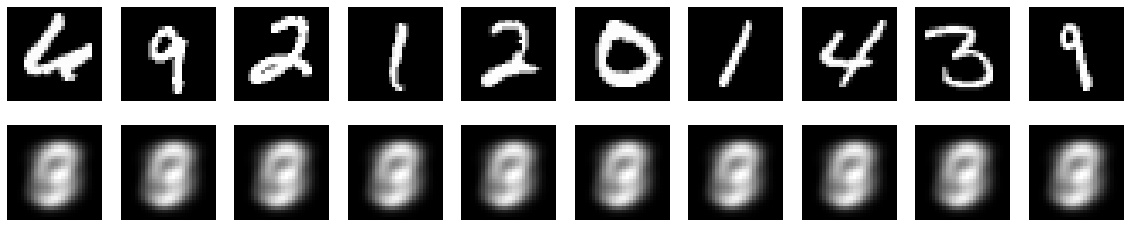

Model con dimension  8


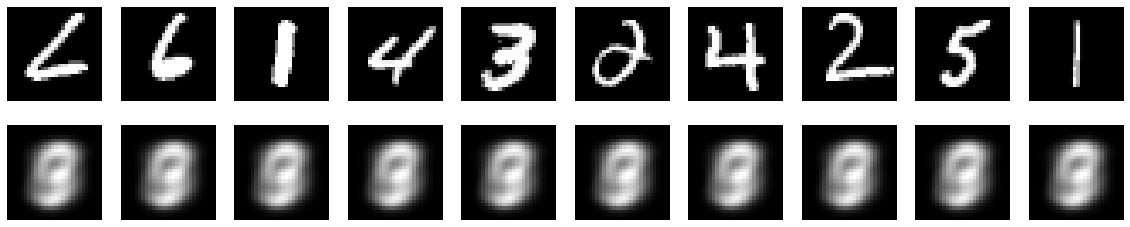

Model con dimension  32


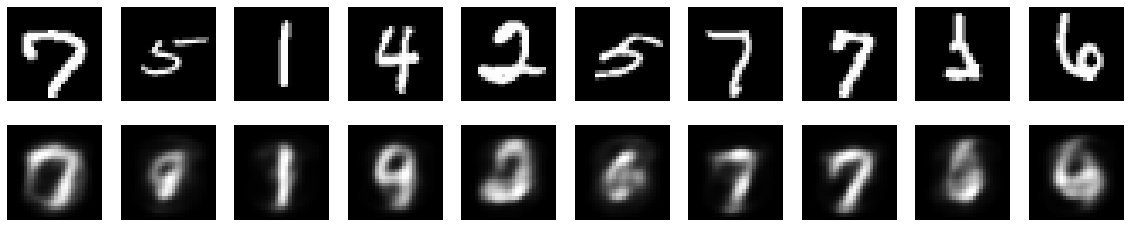

Model con dimension  64


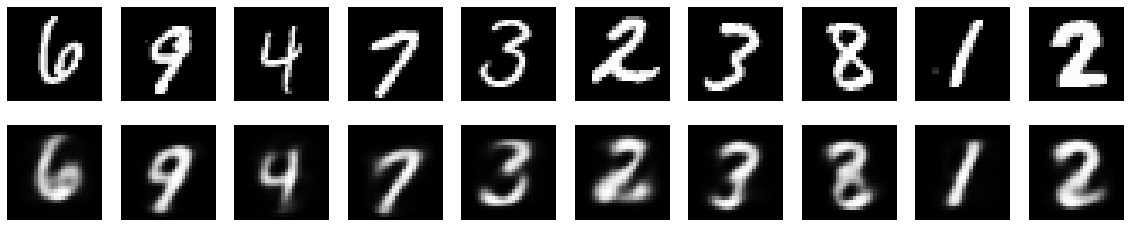

In [0]:
import matplotlib.pyplot as plt
from keras.models import Model

for d in [2,8,32,64]:
  print('Model con dimension ',d)
  autoencoder = keras.models.load_model('basic_autoencoder_768x'+str(d)+'.h5')

  input_img = Input(shape=(784,))
  encoded = autoencoder.layers[0](input_img)
  encoder = Model(input=input_img, output=encoded)
  
  encoded_test = encoder.predict(x_test)
  decoded_test = autoencoder.predict(encoded_test)

  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
      j = np.random.randint(0,len(x_test))
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

### Comparación AE para reducción de dimensionalidad contra PCA

In [0]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

for d in [2,8,32,64]:
  print("Dimension encoder y componentes PCA: ",d)
  pca = PCA(n_components=d)
  pca.fit(x_train)
  pca_train = pca.transform(x_train)
  pca_test = pca.transform(x_test)

  #AUTOENCODER
  autoencoder = keras.models.load_model('basic_autoencoder_768x'+str(d)+'.h5')
  encoded_train = encoder.predict(x_train)
  encoded_test = encoder.predict(x_test)
  
  #CLASIFICATION
  clf = KNeighborsClassifier(10)
  clf.fit(pca_train, y_train)
  print('Classification Accuracy PCA', clf.score(pca_test,y_test))
  clf = KNeighborsClassifier(10)
  clf.fit(encoded_train, y_train)
  print('Classification Accuracy encoders', clf.score(encoded_test,y_test))
  
  

Dimension encoder y componentes PCA:  2
Classification Accuracy PCA 0.4405
Classification Accuracy encoders 0.9567
Dimension encoder y componentes PCA:  8
Classification Accuracy PCA 0.905
Classification Accuracy encoders 0.9567
Dimension encoder y componentes PCA:  32
Classification Accuracy PCA 0.9742
Classification Accuracy encoders 0.9567
Dimension encoder y componentes PCA:  64
Classification Accuracy PCA 0.9732
Classification Accuracy encoders 0.9567


### Comparación deep AE contra "shallow" AE


#### 4 capas, con diferentes dimensiones

In [0]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD

for d in [2,8,32,64]:                      
  target_dim = d #try other and do a nice plot
  input_img = Input(shape=(784,))
  encoded1 = Dense(1000, activation='relu')(input_img)
  encoded2 = Dense(500, activation='relu')(encoded1)
  encoded3 = Dense(250, activation='relu')(encoded2)
  encoded4 = Dense(target_dim, activation='relu')(encoded3)
  
  decoded4 = Dense(250, activation='relu')(encoded4)
  decoded3 = Dense(500, activation='relu')(decoded4)
  decoded2 = Dense(1000, activation='relu')(decoded3)
  decoded1 = Dense(784, activation='sigmoid')(decoded2)
  
  autoencoder = Model(input=input_img, output=decoded1)
  encoder = Model(input=input_img, output=encoded3)
  autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
  autoencoder.fit(x_train,x_train,epochs=10,batch_size=32,validation_data=(x_val,x_val))
  autoencoder.save('my_autoencoder_768x1000x500x250x'+str(d)+'.h5')
                                        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 70s 1ms/step - loss: 0.2699 - val_loss: 0.2335
Epoch 2/10
55000/55000 [==============================] - 70s 1ms/step - loss: 0.2240 - val_loss: 0.2159
Epoch 3/10
55000/55000 [==============================] - 68s 1ms/step - loss: 0.2198 - val_loss: 0.2351
Epoch 4/10
55000/55000 [==============================] - 68s 1ms/step - loss: 0.2249 - val_loss: 0.2393
Epoch 5/10
55000/55000 [==============================] - 68s 1ms/step - loss: 0.2222 - val_loss: 0.2156
Epoch 6/10
55000/55000 [==============================] - 68s 1ms/step - loss: 0.2207 - val_loss: 0.2210
Epoch 7/10
55000/55000 [==============================] - 69s 1ms/step - loss: 0.2193 - val_loss: 0.2136
Epoch 8/10
55000/55000 [==============================] - 69s 1ms/step - loss: 0.2218 - val_loss: 0.2279
Epoch 9/10
55000/55000 [==============================] - 69s 1ms/step - loss: 0.2213 - val_loss: 0.2213
Epoch 

#### Visualización

Dimension encoder y componentes PCA:  2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


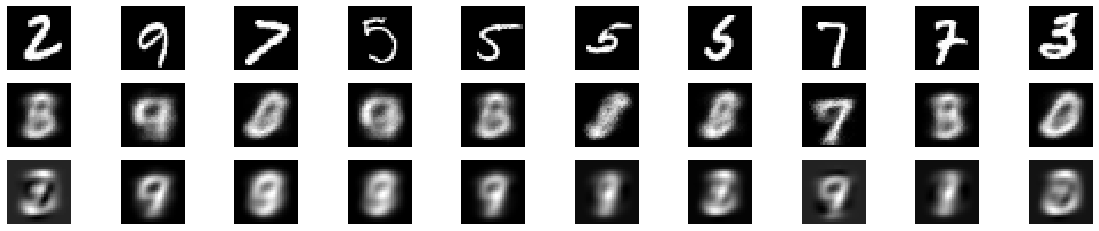

Classification Accuracy PCA 0.4404
Classification Accuracy encoders 0.447




Dimension encoder y componentes PCA:  8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


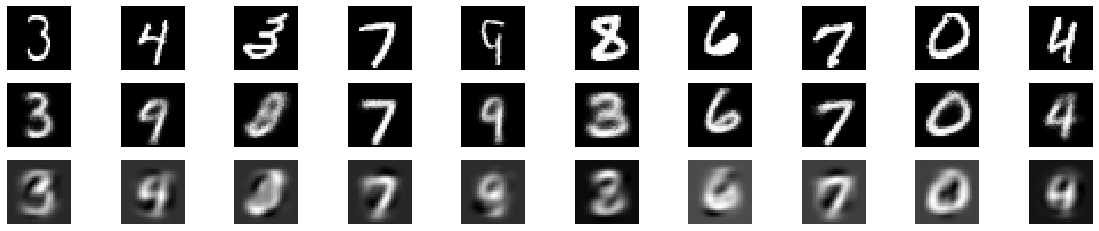

Classification Accuracy PCA 0.905
Classification Accuracy encoders 0.8502




Dimension encoder y componentes PCA:  32


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


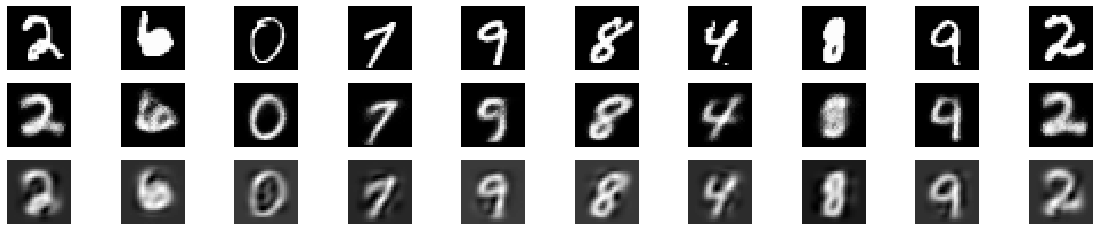

Classification Accuracy PCA 0.9743
Classification Accuracy encoders 0.876




Dimension encoder y componentes PCA:  64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


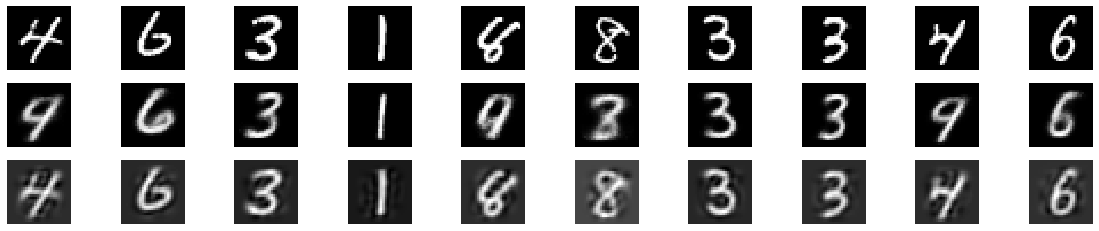

Classification Accuracy PCA 0.9732
Classification Accuracy encoders 0.8784






In [0]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import keras

# evaluate PCA and encoder
for d in [2,8,32,64]:
  print("Dimension encoder y componentes PCA: ",d)
  pca = PCA(n_components=d)
  pca.fit(x_train)
  pca_train = pca.transform(x_train)
  pca_test = pca.transform(x_test)

  #AUTOENCODER
  autoencoder = keras.models.load_model('my_autoencoder_768x1000x500x250x'+str(d)+'.h5')
  #autoencoder.summary()

  input_img = Input(shape=(784,))
  encoded = autoencoder.layers[1](input_img)
  encoded = autoencoder.layers[2](encoded)
  encoded = autoencoder.layers[3](encoded)
  encoded = autoencoder.layers[4](encoded)
  encoder = Model(input=input_img, output=encoded)
  
  encoded_train = encoder.predict(x_train)
  encoded_test = encoder.predict(x_test)
  
  decoded_test = autoencoder.predict(x_test)
  decoded_test_PCA = pca.inverse_transform(pca_test)
  
  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
      j = np.random.randint(0,len(x_test))
      ax = plt.subplot(3, n, i + 1)
      plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
      ax = plt.subplot(3, n, i + 1 + 2*n)
      plt.imshow(decoded_test_PCA[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
  plt.show()
  
  #CLASIFICATION
  clf = KNeighborsClassifier(10)
  clf.fit(pca_train, y_train)
  print('Classification Accuracy PCA', clf.score(pca_test,y_test))
  clf = KNeighborsClassifier(10)
  clf.fit(encoded_train, y_train)
  print('Classification Accuracy encoders', clf.score(encoded_test,y_test))
  print("\n\n\n")

#### 3 capas con diferentes dimensiones

In [0]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD

for d in [2,8,32,64]:                      
  target_dim = d #try other and do a nice plot
  input_img = Input(shape=(784,))
  encoded1 = Dense(1000, activation='relu')(input_img)
  encoded2 = Dense(500, activation='relu')(encoded1)
  encoded3 = Dense(target_dim, activation='relu')(encoded2)
  
  decoded3 = Dense(500, activation='relu')(encoded3)
  decoded2 = Dense(1000, activation='relu')(decoded3)
  decoded1 = Dense(784, activation='sigmoid')(decoded2)
  
  autoencoder = Model(input=input_img, output=decoded1)
  encoder = Model(input=input_img, output=encoded3)
  autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
  autoencoder.fit(x_train,x_train,epochs=10,batch_size=32,validation_data=(x_val,x_val))
  autoencoder.save('my_autoencoder_768x1000x500x'+str(d)+'.h5')
                                        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 67s 1ms/step - loss: 0.2654 - val_loss: 0.2516
Epoch 2/10
55000/55000 [==============================] - 62s 1ms/step - loss: 0.2460 - val_loss: 0.2455
Epoch 3/10
55000/55000 [==============================] - 61s 1ms/step - loss: 0.2510 - val_loss: 0.2413
Epoch 4/10
55000/55000 [==============================] - 62s 1ms/step - loss: 0.2433 - val_loss: 0.2455
Epoch 5/10
55000/55000 [==============================] - 62s 1ms/step - loss: 0.2438 - val_loss: 0.2458
Epoch 6/10
55000/55000 [==============================] - 62s 1ms/step - loss: 0.2445 - val_loss: 0.2408
Epoch 7/10
55000/55000 [==============================] - 63s 1ms/step - loss: 0.2455 - val_loss: 0.2486
Epoch 8/10
55000/55000 [==============================] - 62s 1ms/step - loss: 0.2461 - val_loss: 0.2475
Epoch 9/10
55000/55000 [==============================] - 62s 1ms/step - loss: 0.2495 - val_loss: 0.2449
Epoch 

#### Visualización

Dimension encoder y componentes PCA:  2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


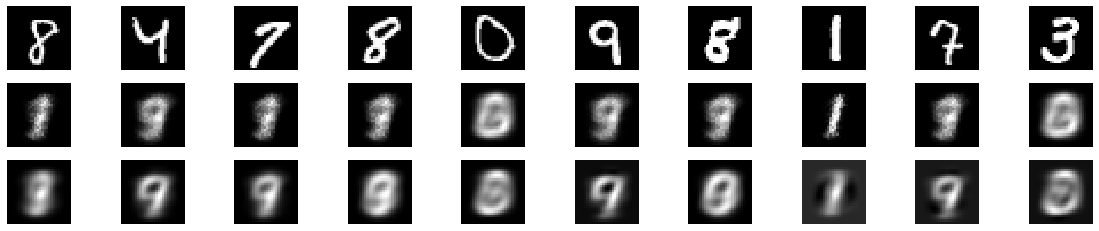

Classification Accuracy PCA 0.4405
Classification Accuracy encoders 0.2643




Dimension encoder y componentes PCA:  8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


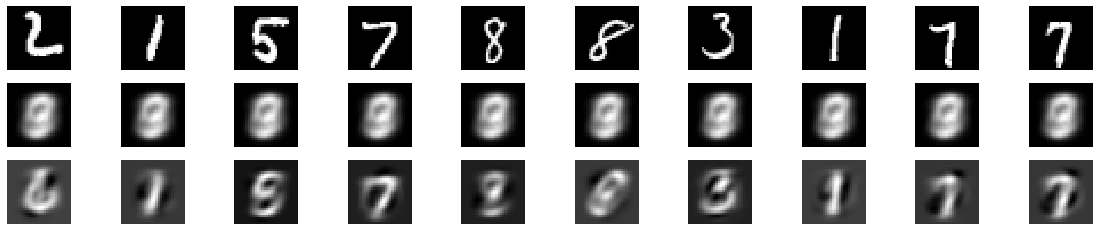

Classification Accuracy PCA 0.905
Classification Accuracy encoders 0.0974




Dimension encoder y componentes PCA:  32


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


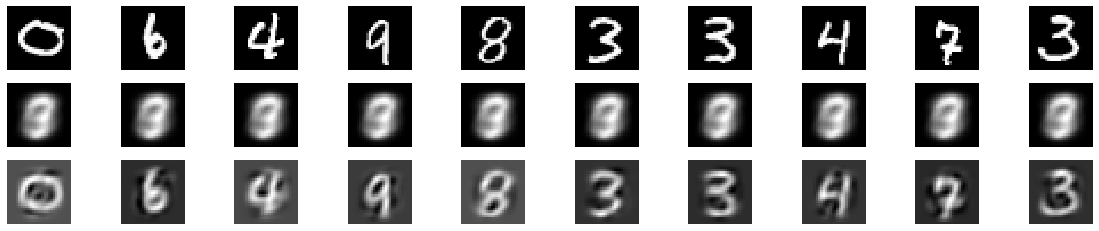

Classification Accuracy PCA 0.9742
Classification Accuracy encoders 0.0974




Dimension encoder y componentes PCA:  64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


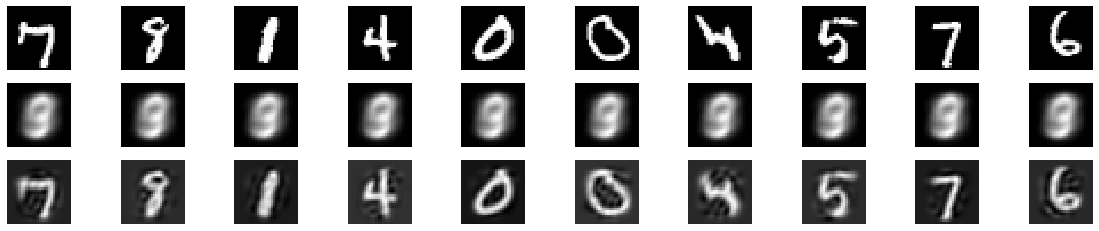

Classification Accuracy PCA 0.9732
Classification Accuracy encoders 0.0974






In [0]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import keras

# evaluate PCA and encoder
for d in [2,8,32,64]:
  print("Dimension encoder y componentes PCA: ",d)
  pca = PCA(n_components=d)
  pca.fit(x_train)
  pca_train = pca.transform(x_train)
  pca_test = pca.transform(x_test)

  #AUTOENCODER
  autoencoder = keras.models.load_model('my_autoencoder_768x1000x500x'+str(d)+'.h5')

  input_img = Input(shape=(784,))
  encoded = autoencoder.layers[1](input_img)
  encoded = autoencoder.layers[2](encoded)
  encoded = autoencoder.layers[3](encoded)
  encoder = Model(input=input_img, output=encoded)
  
  encoded_train = encoder.predict(x_train)
  encoded_test = encoder.predict(x_test)
  
  decoded_test = autoencoder.predict(x_test)
  decoded_test_PCA = pca.inverse_transform(pca_test)
  
  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
      j = np.random.randint(0,len(x_test))
      ax = plt.subplot(3, n, i + 1)
      plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
      ax = plt.subplot(3, n, i + 1 + 2*n)
      plt.imshow(decoded_test_PCA[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
  plt.show()
  
  #CLASIFICATION
  clf = KNeighborsClassifier(10)
  clf.fit(pca_train, y_train)
  print('Classification Accuracy PCA', clf.score(pca_test,y_test))
  clf = KNeighborsClassifier(10)
  clf.fit(encoded_train, y_train)
  print('Classification Accuracy encoders', clf.score(encoded_test,y_test))
  print("\n\n\n")

#### 2 capas con diferentes dimensiones

In [0]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD

for d in [2,8,32,64]:                      
  target_dim = d #try other and do a nice plot
  input_img = Input(shape=(784,))
  encoded1 = Dense(1000, activation='relu')(input_img)
  encoded2 = Dense(target_dim, activation='relu')(encoded1)
  
  decoded2 = Dense(1000, activation='relu')(encoded2)
  decoded1 = Dense(784, activation='sigmoid')(decoded2)
  
  autoencoder = Model(input=input_img, output=decoded1)
  encoder = Model(input=input_img, output=encoded2)
  autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
  autoencoder.fit(x_train,x_train,epochs=10,batch_size=32,validation_data=(x_val,x_val))
  autoencoder.save('my_autoencoder_768x1000x'+str(d)+'.h5')
                                        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 34s 612us/step - loss: 0.2747 - val_loss: 0.2363
Epoch 2/10
55000/55000 [==============================] - 33s 596us/step - loss: 0.2316 - val_loss: 0.2268
Epoch 3/10
55000/55000 [==============================] - 32s 584us/step - loss: 0.2244 - val_loss: 0.2210
Epoch 4/10
55000/55000 [==============================] - 32s 574us/step - loss: 0.2192 - val_loss: 0.2164
Epoch 5/10
55000/55000 [==============================] - 31s 569us/step - loss: 0.2154 - val_loss: 0.2136
Epoch 6/10
55000/55000 [==============================] - 32s 580us/step - loss: 0.2132 - val_loss: 0.2115
Epoch 7/10
55000/55000 [==============================] - 32s 582us/step - loss: 0.2116 - val_loss: 0.2096
Epoch 8/10
55000/55000 [==============================] - 32s 573us/step - loss: 0.2103 - val_loss: 0.2088
Epoch 9/10
55000/55000 [==============================] - 31s 564us/step - loss: 0.2092 - val_l

#### Visualización

Dimension encoder y componentes PCA:  2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


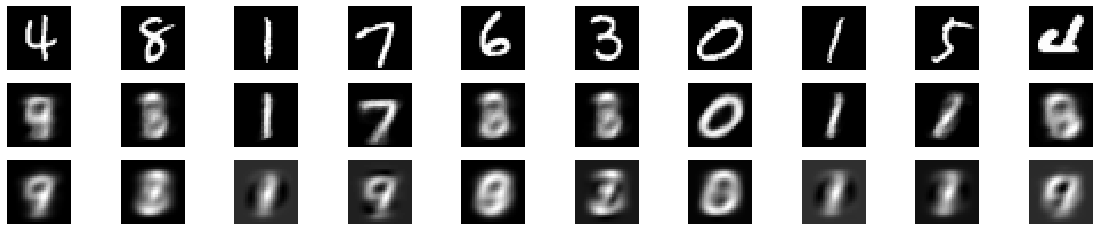

Classification Accuracy PCA 0.4404
Classification Accuracy encoders 0.5009




Dimension encoder y componentes PCA:  8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


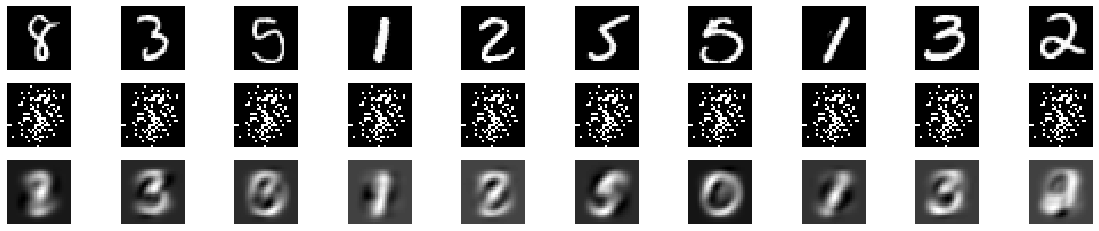

Classification Accuracy PCA 0.9048
Classification Accuracy encoders 0.7228




Dimension encoder y componentes PCA:  32


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


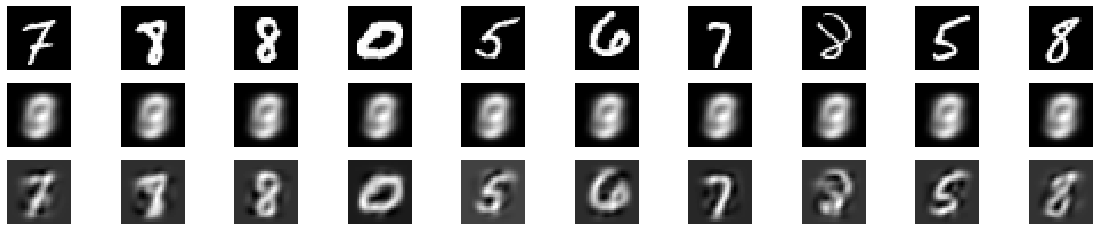

Classification Accuracy PCA 0.9745
Classification Accuracy encoders 0.8795




Dimension encoder y componentes PCA:  64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


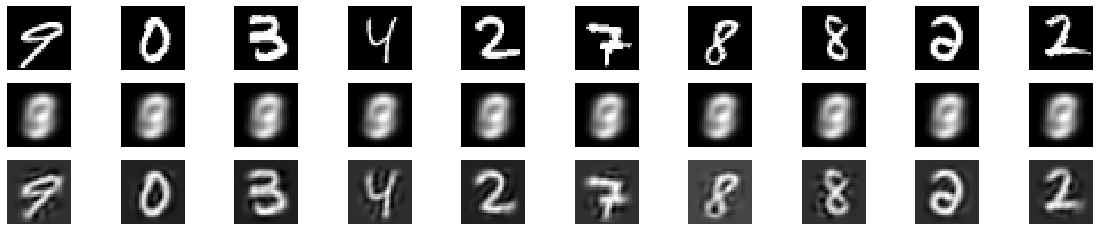

Classification Accuracy PCA 0.9734
Classification Accuracy encoders 0.9199






In [0]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import keras

# evaluate PCA and encoder
for d in [2,8,32,64]:
  print("Dimension encoder y componentes PCA: ",d)
  pca = PCA(n_components=d)
  pca.fit(x_train)
  pca_train = pca.transform(x_train)
  pca_test = pca.transform(x_test)

  #AUTOENCODER
  autoencoder = keras.models.load_model('my_autoencoder_768x1000x'+str(d)+'.h5')

  input_img = Input(shape=(784,))
  encoded = autoencoder.layers[1](input_img)
  encoded = autoencoder.layers[2](encoded)
  encoder = Model(input=input_img, output=encoded)
  
  encoded_train = encoder.predict(x_train)
  encoded_test = encoder.predict(x_test)
  
  decoded_test = autoencoder.predict(x_test)
  decoded_test_PCA = pca.inverse_transform(pca_test)
  
  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
      j = np.random.randint(0,len(x_test))
      ax = plt.subplot(3, n, i + 1)
      plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
      ax = plt.subplot(3, n, i + 1 + 2*n)
      plt.imshow(decoded_test_PCA[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
  plt.show()
  
  #CLASIFICATION
  clf = KNeighborsClassifier(10)
  clf.fit(pca_train, y_train)
  print('Classification Accuracy PCA', clf.score(pca_test,y_test))
  clf = KNeighborsClassifier(10)
  clf.fit(encoded_train, y_train)
  print('Classification Accuracy encoders', clf.score(encoded_test,y_test))
  print("\n\n\n")

### TSNE y visualizaciones

In [0]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD

dim = 64
input_img = Input(shape=(784,))
encoded = Dense(dim, activation='sigmoid')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencode[diego@bebop tarea_3]$ jupyter notebook
r = Model(input=input_img, output=decoded)
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,validation_data=(x_val,x_val))
autoencoder.save('basic_autoencoder.h5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 7s 126us/step - loss: 0.2900 - val_loss: 0.2656
Epoch 2/50
55000/55000 [==============================] - 6s 117us/step - loss: 0.2646 - val_loss: 0.2639
Epoch 3/50
55000/55000 [==============================] - 6s 117us/step - loss: 0.2625 - val_loss: 0.2600
Epoch 4/50
55000/55000 [==============================] - 6s 117us/step - loss: 0.2562 - val_loss: 0.2521
Epoch 5/50
55000/55000 [==============================] - 6s 117us/step - loss: 0.2482 - val_loss: 0.2438
Epoch 6/50
55000/55000 [==============================] - 6s 118us/step - loss: 0.2393 - val_loss: 0.2343
Epoch 7/50
55000/55000 [==============================] - 6s 117us/step - loss: 0.2302 - val_loss: 0.2254
Epoch 8/50
55000/55000 [==============================] - 6s 117us/step - loss: 0.2221 - val_loss: 0.2179
Epoch 9/50
55000/55000 [==============================] - 7s 119us/step - loss: 0.2153 - val_loss: 0.21

In [0]:
dim = 2
input_img = Input(shape=(784,))
encoded = Dense(dim, activation='sigmoid')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input=input_img, output=decoded)
encoder2d = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,validation_data=(x_val,x_val))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 6s 104us/step - loss: 0.4583 - val_loss: 0.3482
Epoch 2/50
55000/55000 [==============================] - 5s 98us/step - loss: 0.3199 - val_loss: 0.3018
Epoch 3/50
55000/55000 [==============================] - 5s 97us/step - loss: 0.2933 - val_loss: 0.2869
Epoch 4/50
55000/55000 [==============================] - 5s 98us/step - loss: 0.2830 - val_loss: 0.2798
Epoch 5/50
55000/55000 [==============================] - 5s 97us/step - loss: 0.2777 - val_loss: 0.2758
Epoch 6/50
55000/55000 [==============================] - 5s 97us/step - loss: 0.2744 - val_loss: 0.2732
Epoch 7/50
55000/55000 [==============================] - 5s 98us/step - loss: 0.2723 - val_loss: 0.2714
Epoch 8/50
55000/55000 [==============================] - 5s 98us/step - loss: 0.2708 - val_loss: 0.2702
Epoch 9/50
55000/55000 [==============================] - 5s 98us/step - loss: 0.2697 - val_loss: 0.2692
Epoch

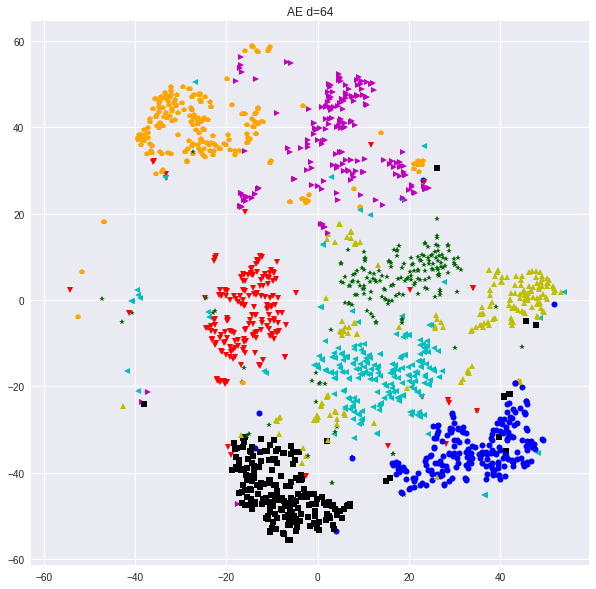

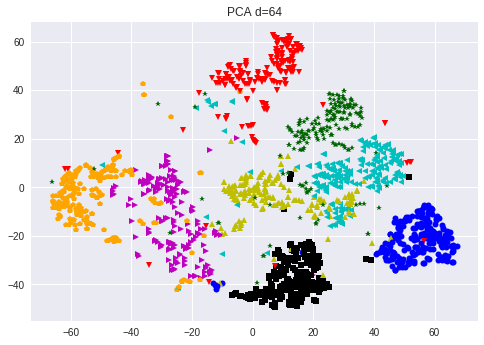

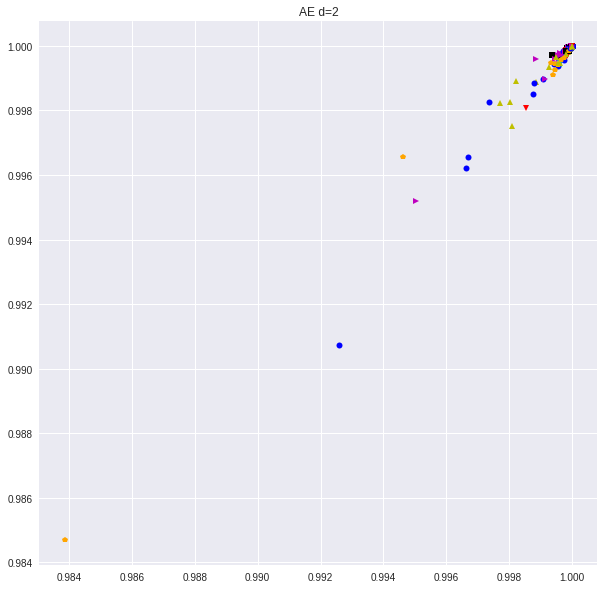

In [0]:
import keras
from sklearn.decomposition import PCA

nplot=2000 #warning: mind your memory!
d=64
encoded_input = Input(shape=(d,))
encoded_train = encoder.predict(x_train[:nplot])

from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
plt.title("AE d=64")
for idx in range(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
plt.show()

# PCA
pca = PCA(n_components=d)
pca.fit(x_train)
pca_train = pca.transform(x_train)
encoded_train = pca_train[:nplot]
encoded_train = model.fit_transform(encoded_train)

plt.title("PCA d=64")
for idx in range(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
plt.show()
    
#plot AE (d=2) without TSNE

encoded_train = encoder2d.predict(x_train[:nplot]) #Autoencoder with d=2
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
plt.title("AE d=2")
for idx in range(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)


### Auto Encoder a través de convoluciones

In [0]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Normalize data
x_train = x_train.astype('float32') / 255. 
x_test = x_test.astype('float32') / 255. 
x_val  = x_train[:5000]
y_val = x_train[:5000]
x_train = x_train[5000:]
y_train = y_train[5000:]
# Convert to vector
x_train = x_train.reshape((x_train.shape[0],x_train[0].size))
x_test = x_test.reshape((x_test.shape[0],x_test[0].size))
x_val = x_val.reshape((x_val.shape[0],x_val[0].size))

dim = 4
input_img = Input(shape=(784,))
encoded = Dense(dim, activation='sigmoid')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input=input_img, output=decoded)
autoencoder.summary()
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,epochs=10,batch_size=32,validation_data=(x_val,x_val))
autoencoder.save('basic_autoencoderxD=4.h5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 3140      
_________________________________________________________________
dense_14 (Dense)             (None, 784)               3920      
Total params: 7,060
Trainable params: 7,060
Non-trainable params: 0
_________________________________________________________________
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 7s 125us/step - loss: 0.4084 - val_loss: 0.3115
Epoch 2/10
55000/55000 [==============================] - 6s 108us/step - loss: 0.2945 - val_loss: 0.2841
Epoch 3/10
55000/55000 [==============================] - 6s 104us/step - loss: 0.2794 - val_loss: 0.2758
Epoch 4/10
55000/55000 [=============

In [0]:


x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) #modify for th dim ordering
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
x_val = np.reshape(x_val, (len(x_val), 28, 28, 1))

from keras.layers import *

input_img = Input(shape=(28, 28, 1))
x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,epochs=10,batch_size=32,validation_data=(x_val,x_val))
autoencoder.save('convEA.h5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 16)        1168      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampling2d_13 (UpSampling (None, 14, 14, 16)        0         
__________

##### Comparación de calidad del autoencoder frente a los demás y comprensión de la dimensionalidad

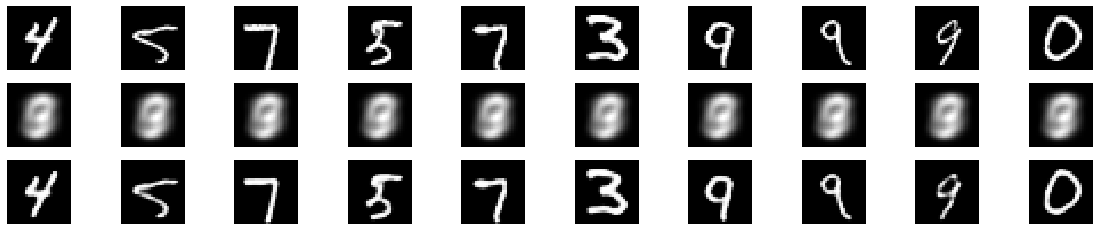

In [0]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

autoencoder = keras.models.load_model('convEA.h5')
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
decoded_test_Conv = autoencoder.predict(x_test)

autoencoder = keras.models.load_model('basic_autoencoderxD=4.h5')
x_test = x_test.reshape((x_test.shape[0],x_test[0].size))
decoded_test_AE = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  j = np.random.randint(0,len(x_test))
  
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
  ax = plt.subplot(3, n, i + 1 + n)
  plt.imshow(decoded_test_AE[j].reshape(28, 28),cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
  ax = plt.subplot(3, n, i + 1 + 2*n)
  plt.imshow(decoded_test_Conv[j].reshape(28, 28),cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
      
plt.show()

## Denoising


#### Autoencoder para reducir ruido

* Primero definimos nuestor modelo de AE
* Luego creamos data con ruido, que estará dentro de un for para variar la probabilidad de ruido
* Luego pasa a entrenarse el modelo
* Se muestran las imagenes reales, las con ruido y las generadas sin ruidos
* Por úlimo se muestra la precisión de la clasificación

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


Noise :  0.1
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 74s 1ms/step - loss: 0.2715 - val_loss: 0.2490
Epoch 2/10
55000/55000 [==============================] - 68s 1ms/step - loss: 0.2441 - val_loss: 0.2403
Epoch 3/10
55000/55000 [==============================] - 68s 1ms/step - loss: 0.2308 - val_loss: 0.2222
Epoch 4/10
55000/55000 [==============================] - 68s 1ms/step - loss: 0.2147 - val_loss: 0.2108
Epoch 5/10
55000/55000 [==============================] - 68s 1ms/step - loss: 0.2111 - val_loss: 0.2071
Epoch 6/10
55000/55000 [==============================] - 68s 1ms/step - loss: 0.2097 - val_loss: 0.2137
Epoch 7/10
55000/55000 [==============================] - 68s 1ms/step - loss: 0.2085 - val_loss: 0.1995
Epoch 8/10
55000/55000 [==============================] - 68s 1ms/step - loss: 0.2057 - val_loss: 0.2037
Epoch 9/10
55000/55000 [==============================] - 69s 1ms/step - loss: 0.2038 - val_loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


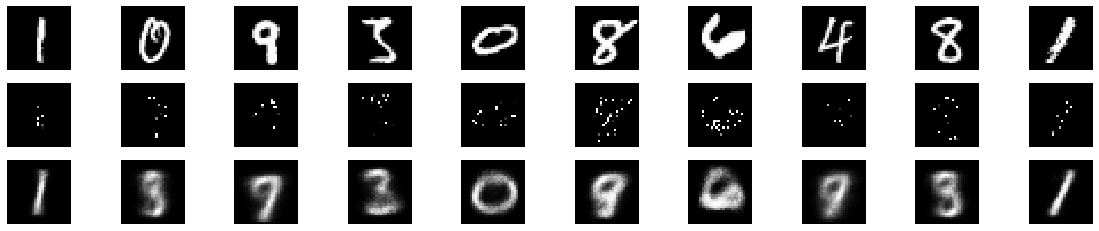

Classification Accuracy encoders 0.5974




Noise :  0.3
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 68s 1ms/step - loss: 0.1677 - val_loss: 0.1641
Epoch 2/10
55000/55000 [==============================] - 68s 1ms/step - loss: 0.1641 - val_loss: 0.1619
Epoch 3/10
55000/55000 [==============================] - 70s 1ms/step - loss: 0.1624 - val_loss: 0.1590
Epoch 4/10
55000/55000 [==============================] - 69s 1ms/step - loss: 0.1613 - val_loss: 0.1717
Epoch 5/10
55000/55000 [==============================] - 69s 1ms/step - loss: 0.1604 - val_loss: 0.1631
Epoch 6/10
55000/55000 [==============================] - 69s 1ms/step - loss: 0.1598 - val_loss: 0.1629
Epoch 7/10
55000/55000 [==============================] - 69s 1ms/step - loss: 0.1590 - val_loss: 0.1633
Epoch 8/10
55000/55000 [==============================] - 68s 1ms/step - loss: 0.1584 - val_loss: 0.1568
Epoch 9/10
55000/55000 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


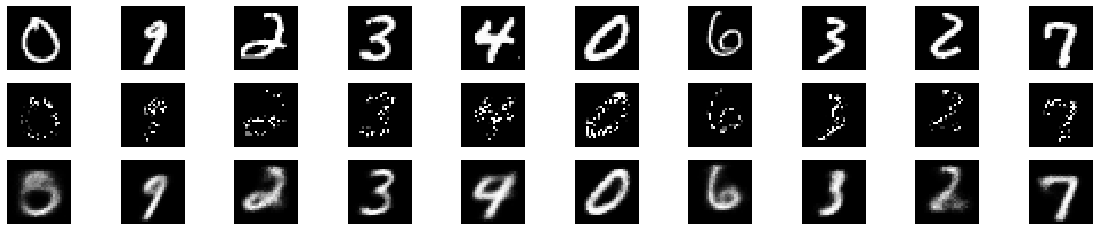

Classification Accuracy encoders 0.8053




Noise :  0.6
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 70s 1ms/step - loss: 0.1451 - val_loss: 0.1448
Epoch 2/10
55000/55000 [==============================] - 69s 1ms/step - loss: 0.1432 - val_loss: 0.1395
Epoch 3/10
55000/55000 [==============================] - 69s 1ms/step - loss: 0.1425 - val_loss: 0.1380
Epoch 4/10
55000/55000 [==============================] - 69s 1ms/step - loss: 0.1415 - val_loss: 0.1453
Epoch 5/10
55000/55000 [==============================] - 69s 1ms/step - loss: 0.1407 - val_loss: 0.1417
Epoch 6/10
55000/55000 [==============================] - 68s 1ms/step - loss: 0.1403 - val_loss: 0.1382
Epoch 7/10
55000/55000 [==============================] - 69s 1ms/step - loss: 0.1395 - val_loss: 0.1413
Epoch 8/10
55000/55000 [==============================] - 69s 1ms/step - loss: 0.1390 - val_loss: 0.1440
Epoch 9/10
55000/55000 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


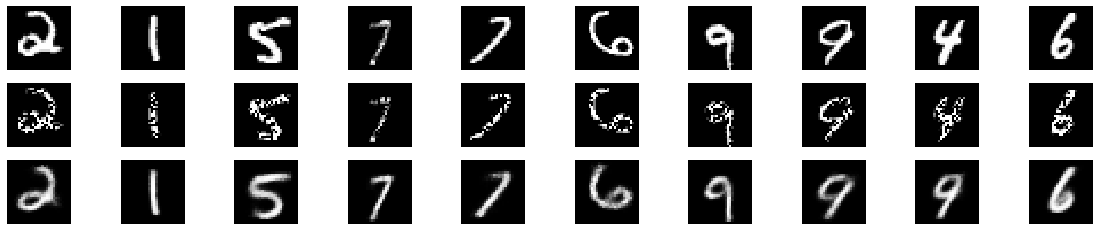

Classification Accuracy encoders 0.8885






In [0]:
[diego@bebop tarea_3]$ jupyter notebook
from numpy.random import binomial

input_img = Input(shape=(784,))
encoded1 = Dense(1000, activation='relu')(input_img)
encoded2 = Dense(500, activation='relu')(encoded1)
encoded3 = Dense(250, activation='relu')(encoded2)
encoded4 = Dense(target_dim, activation='relu')(encoded3)
  
decoded4 = Dense(250, activation='relu')(encoded4)
decoded3 = Dense(500, activation='relu')(decoded4)
decoded2 = Dense(1000, activation='relu')(decoded3)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
  
autoencoder = Model(input=input_img, output=decoded1)
encoder = Model(input=input_img, output=encoded3)
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')

# autoencoder.save('my_autoencoder_768x1000x500x250x'+str(d)+'.h5')

# evaluate PCA and encoder
for noise_level in [0.1,0.3,0.6]:
  print("Noise : ",noise_level)
  
  # Noise image
  noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
  noisy_x_train = x_train*noise_mask
  noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
  noisy_x_val = x_val*noise_mask
  noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
  noisy_x_test = x_test*noise_mask
  
  #AUTOENCODER
  autoencoder.fit(noisy_x_train, x_train, epochs=10, batch_size=32, validation_data=(noisy_x_val, x_val))
  
  input_img = Input(shape=(784,))
  encoded = autoencoder.layers[1](input_img)
  encoded = autoencoder.layers[2](encoded)
  encoded = autoencoder.layers[3](encoded)
  encoded = autoencoder.layers[4](encoded)
  encoder = Model(input=input_img, output=encoded)
  
  encoded_train = encoder.predict(noisy_x_train)
  encoded_test = encoder.predict(noisy_x_test)
  
  # Image generated without noise by AE
  decoded_test = autoencoder.predict(noisy_x_test)
  
  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
      j = np.random.randint(0,len(x_test))
      # original image
      ax = plt.subplot(3, n, i + 1)
      plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
      # image with noise
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(noisy_x_test[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
      # predict image without noise
      ax = plt.subplot(3, n, i + 1 + 2*n)
      plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
  plt.show()
  
  #CLASIFICATION
  clf = KNeighborsClassifier(10)
  clf.fit(encoded_train, y_train)
  print('Classification Accuracy encoders', clf.score(encoded_test,y_test))
  print("\n\n\n")


### AE para reducir ruido pero con otra generación de ruido


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


std :  1
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 67s 1ms/step - loss: 0.2422 - val_loss: 0.2059
Epoch 2/10
55000/55000 [==============================] - 67s 1ms/step - loss: 0.2273 - val_loss: 0.2642
Epoch 3/10
55000/55000 [==============================] - 72s 1ms/step - loss: 0.2368 - val_loss: 0.2130
Epoch 4/10
55000/55000 [==============================] - 74s 1ms/step - loss: 0.2077 - val_loss: 0.2025
Epoch 5/10
55000/55000 [==============================] - 73s 1ms/step - loss: 0.2000 - val_loss: 0.1975
Epoch 6/10
55000/55000 [==============================] - 72s 1ms/step - loss: 0.1962 - val_loss: 0.1904
Epoch 7/10
55000/55000 [==============================] - 70s 1ms/step - loss: 0.1936 - val_loss: 0.1893
Epoch 8/10
55000/55000 [==============================] - 70s 1ms/step - loss: 0.1915 - val_loss: 0.1924
Epoch 9/10
55000/55000 [==============================] - 67s 1ms/step - loss: 0.1899 - val_loss: 0.19

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


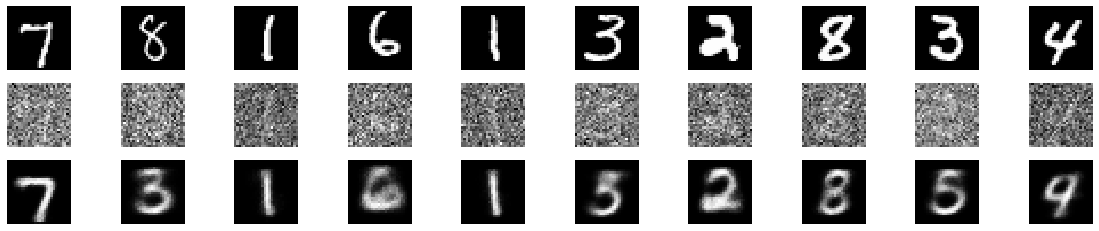

Classification Accuracy encoders 0.6669




std :  2
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 61s 1ms/step - loss: 0.2252 - val_loss: 0.2233
Epoch 2/10
55000/55000 [==============================] - 60s 1ms/step - loss: 0.2226 - val_loss: 0.2238
Epoch 3/10
55000/55000 [==============================] - 59s 1ms/step - loss: 0.2213 - val_loss: 0.2217
Epoch 4/10
55000/55000 [==============================] - 60s 1ms/step - loss: 0.2204 - val_loss: 0.2223
Epoch 5/10
55000/55000 [==============================] - 60s 1ms/step - loss: 0.2196 - val_loss: 0.2218
Epoch 6/10
55000/55000 [==============================] - 61s 1ms/step - loss: 0.2191 - val_loss: 0.2216
Epoch 7/10
55000/55000 [==============================] - 61s 1ms/step - loss: 0.2184 - val_loss: 0.2212
Epoch 8/10
55000/55000 [==============================] - 61s 1ms/step - loss: 0.2179 - val_loss: 0.2239
Epoch 9/10
55000/55000 [==============================] - 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


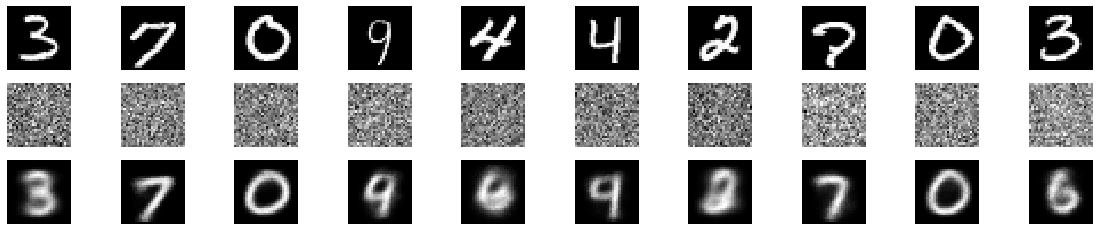

Classification Accuracy encoders 0.4299




std :  3
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 59s 1ms/step - loss: 0.2419 - val_loss: 0.2425
Epoch 2/10
55000/55000 [==============================] - 58s 1ms/step - loss: 0.2401 - val_loss: 0.2429
Epoch 3/10
55000/55000 [==============================] - 58s 1ms/step - loss: 0.2391 - val_loss: 0.2407
Epoch 4/10
55000/55000 [==============================] - 56s 1ms/step - loss: 0.2383 - val_loss: 0.2446
Epoch 5/10
55000/55000 [==============================] - 57s 1ms/step - loss: 0.2377 - val_loss: 0.2413
Epoch 6/10
55000/55000 [==============================] - 56s 1ms/step - loss: 0.2371 - val_loss: 0.2437
Epoch 7/10
55000/55000 [==============================] - 57s 1ms/step - loss: 0.2366 - val_loss: 0.2414
Epoch 8/10
55000/55000 [==============================] - 56s 1ms/step - loss: 0.2362 - val_loss: 0.2423
Epoch 9/10
55000/55000 [==============================] - 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


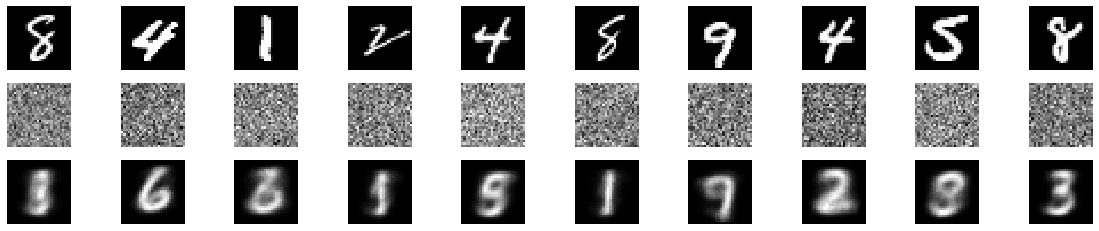

Classification Accuracy encoders 0.2903






In [0]:
from numpy.random import binomial,normal

input_img = Input(shape=(784,))
encoded1 = Dense(1000, activation='relu')(input_img)
encoded2 = Dense(500, activation='relu')(encoded1)
encoded3 = Dense(250, activation='relu')(encoded2)
encoded4 = Dense(target_dim, activation='relu')(encoded3)
  
decoded4 = Dense(250, activation='relu')(encoded4)
decoded3 = Dense(500, activation='relu')(decoded4)
decoded2 = Dense(1000, activation='relu')(decoded3)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
  
autoencoder = Model(input=input_img, output=decoded1)
encoder = Model(input=input_img, output=encoded3)
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')

# autoencoder.save('my_autoencoder_768x1000x500x250x'+str(d)+'.h5')

# evaluate PCA and encoder
for std in [1,2,3]:
  print("std : ",std)
  
  # Noise image
  noisy_x_train = x_train + normal(scale=std, size=x_train.shape)
  noisy_x_val = x_val + normal(scale=std, size=x_val.shape)
  noisy_x_test = x_test + normal(scale=std, size=x_test.shape)
  
  # Re-size 
  noisy_x_train = noisy_x_train.reshape((noisy_x_train.shape[0],noisy_x_train[0].size))
  noisy_x_test = noisy_x_test.reshape((noisy_x_test.shape[0],noisy_x_test[0].size))
  noisy_x_val = noisy_x_val.reshape((noisy_x_val.shape[0],noisy_x_val[0].size))
  
  #AUTOENCODER
  autoencoder.fit(noisy_x_train, x_train, epochs=10, batch_size=32, validation_data=(noisy_x_val, x_val))
  
  input_img = Input(shape=(784,))
  encoded = autoencoder.layers[1](input_img)
  encoded = autoencoder.layers[2](encoded)
  encoded = autoencoder.layers[3](encoded)
  encoded = autoencoder.layers[4](encoded)
  encoder = Model(input=input_img, output=encoded)
  
  encoded_train = encoder.predict(noisy_x_train)
  encoded_test = encoder.predict(noisy_x_test)
  
  # Image generated without noise by AE
  decoded_test = autoencoder.predict(noisy_x_test)
  
  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
      j = np.random.randint(0,len(x_test))
      # original image
      ax = plt.subplot(3, n, i + 1)
      plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
      # image with noise
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(noisy_x_test[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
      # predict image without noise
      ax = plt.subplot(3, n, i + 1 + 2*n)
      plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
  plt.show()
  
  #CLASIFICATION
  clf = KNeighborsClassifier(10)
  clf.fit(encoded_train, y_train)
  print('Classification Accuracy encoders', clf.score(encoded_test,y_test))
  print("\n\n\n")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


std :  0.1
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 57s 1ms/step - loss: 0.2248 - val_loss: 0.1824
Epoch 2/10
55000/55000 [==============================] - 55s 996us/step - loss: 0.2058 - val_loss: 0.1760
Epoch 3/10
55000/55000 [==============================] - 54s 979us/step - loss: 0.1746 - val_loss: 0.1621
Epoch 4/10
55000/55000 [==============================] - 54s 978us/step - loss: 0.1660 - val_loss: 0.1537
Epoch 5/10
55000/55000 [==============================] - 51s 932us/step - loss: 0.1600 - val_loss: 0.1500
Epoch 6/10
55000/55000 [==============================] - 55s 1000us/step - loss: 0.1564 - val_loss: 0.1498
Epoch 7/10
55000/55000 [==============================] - 59s 1ms/step - loss: 0.1531 - val_loss: 0.1544
Epoch 8/10
55000/55000 [==============================] - 58s 1ms/step - loss: 0.1504 - val_loss: 0.1441
Epoch 9/10
55000/55000 [==============================] - 59s 1ms/step - loss: 0.1481 - v

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


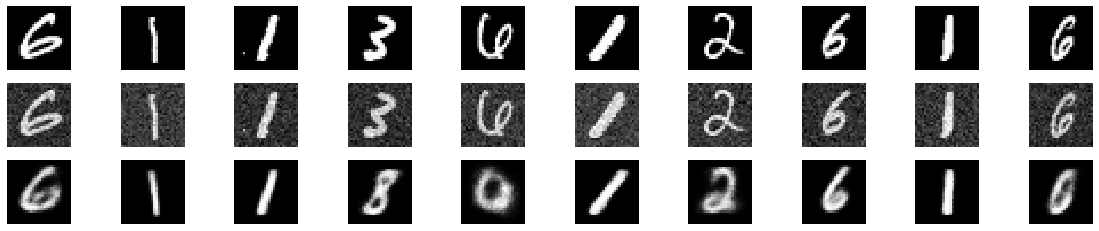

Classification Accuracy encoders 0.8957




std :  0.01
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 58s 1ms/step - loss: 0.1438 - val_loss: 0.1439
Epoch 2/10
55000/55000 [==============================] - 57s 1ms/step - loss: 0.1425 - val_loss: 0.1406
Epoch 3/10
55000/55000 [==============================] - 57s 1ms/step - loss: 0.1412 - val_loss: 0.1397
Epoch 4/10
55000/55000 [==============================] - 55s 1ms/step - loss: 0.1403 - val_loss: 0.1393
Epoch 5/10
55000/55000 [==============================] - 55s 996us/step - loss: 0.1391 - val_loss: 0.1349
Epoch 6/10
55000/55000 [==============================] - 54s 989us/step - loss: 0.1388 - val_loss: 0.1453
Epoch 7/10
55000/55000 [==============================] - 55s 1ms/step - loss: 0.1377 - val_loss: 0.1335
Epoch 8/10
55000/55000 [==============================] - 54s 988us/step - loss: 0.1374 - val_loss: 0.1346
Epoch 9/10
55000/55000 [=========================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


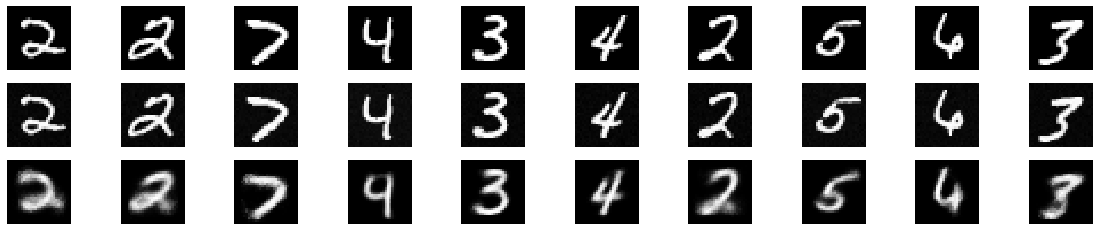

Classification Accuracy encoders 0.9046




std :  0.001
Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 55s 1ms/step - loss: 0.1358 - val_loss: 0.1344
Epoch 2/10
55000/55000 [==============================] - 56s 1ms/step - loss: 0.1350 - val_loss: 0.1331
Epoch 3/10
55000/55000 [==============================] - 61s 1ms/step - loss: 0.1349 - val_loss: 0.1307
Epoch 4/10
55000/55000 [==============================] - 60s 1ms/step - loss: 0.1344 - val_loss: 0.1379
Epoch 5/10
55000/55000 [==============================] - 60s 1ms/step - loss: 0.1343 - val_loss: 0.1375
Epoch 6/10
55000/55000 [==============================] - 60s 1ms/step - loss: 0.1339 - val_loss: 0.1376
Epoch 7/10
55000/55000 [==============================] - 57s 1ms/step - loss: 0.1333 - val_loss: 0.1324
Epoch 8/10
55000/55000 [==============================] - 58s 1ms/step - loss: 0.1335 - val_loss: 0.1371
Epoch 9/10
55000/55000 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


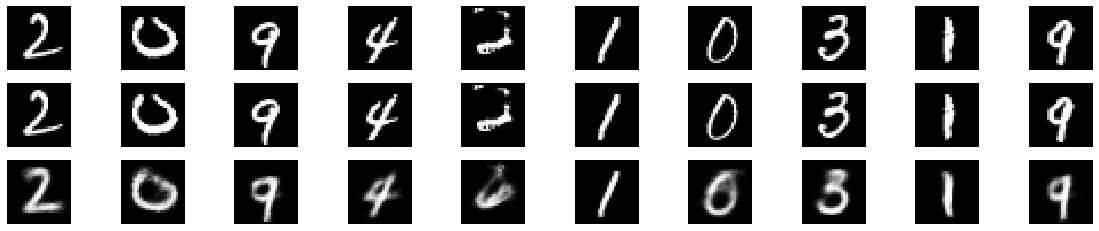

Classification Accuracy encoders 0.9068






In [0]:
from numpy.random import binomial,normal

input_img = Input(shape=(784,))
encoded1 = Dense(1000, activation='relu')(input_img)
encoded2 = Dense(500, activation='relu')(encoded1)
encoded3 = Dense(250, activation='relu')(encoded2)
encoded4 = Dense(target_dim, activation='relu')(encoded3)
  
decoded4 = Dense(250, activation='relu')(encoded4)
decoded3 = Dense(500, activation='relu')(decoded4)
decoded2 = Dense(1000, activation='relu')(decoded3)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
  
autoencoder = Model(input=input_img, output=decoded1)
encoder = Model(input=input_img, output=encoded3)
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')

# autoencoder.save('my_autoencoder_768x1000x500x250x'+str(d)+'.h5')

# evaluate PCA and encoder
for std in [0.1,0.01,0.001]:
  print("std : ",std)
  
  # Noise image
  noisy_x_train = x_train + normal(scale=std, size=x_train.shape)
  noisy_x_val = x_val + normal(scale=std, size=x_val.shape)
  noisy_x_test = x_test + normal(scale=std, size=x_test.shape)
  
  # Re-size 
  noisy_x_train = noisy_x_train.reshape((noisy_x_train.shape[0],noisy_x_train[0].size))
  noisy_x_test = noisy_x_test.reshape((noisy_x_test.shape[0],noisy_x_test[0].size))
  noisy_x_val = noisy_x_val.reshape((noisy_x_val.shape[0],noisy_x_val[0].size))
  
  #AUTOENCODER
  autoencoder.fit(noisy_x_train, x_train, epochs=10, batch_size=32, validation_data=(noisy_x_val, x_val))
  
  input_img = Input(shape=(784,))
  encoded = autoencoder.layers[1](input_img)
  encoded = autoencoder.layers[2](encoded)
  encoded = autoencoder.layers[3](encoded)
  encoded = autoencoder.layers[4](encoded)
  encoder = Model(input=input_img, output=encoded)
  
  encoded_train = encoder.predict(noisy_x_train)
  encoded_test = encoder.predict(noisy_x_test)
  
  # Image generated without noise by AE
  decoded_test = autoencoder.predict(noisy_x_test)
  
  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
      j = np.random.randint(0,len(x_test))
      # original image
      ax = plt.subplot(3, n, i + 1)
      plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
      # image with noise
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(noisy_x_test[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
      # predict image without noise
      ax = plt.subplot(3, n, i + 1 + 2*n)
      plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
  plt.show()
  
  #CLASIFICATION
  clf = KNeighborsClassifier(10)
  clf.fit(encoded_train, y_train)
  print('Classification Accuracy encoders', clf.score(encoded_test,y_test))
  print("\n\n\n")

## Similarity reconstruct 
Consiste en generar data similar a la que se tiene

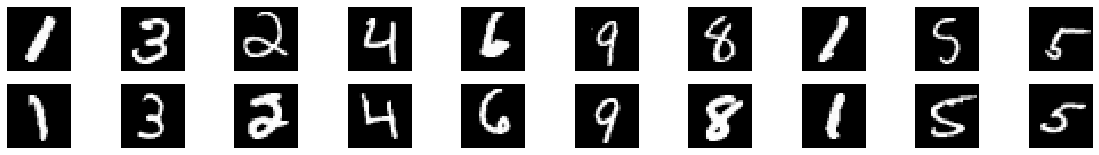

In [0]:
import matplotlib.pyplot as plt

def similarity_data(X,Y,sim=10):
    index_classes = [ np.where(Y==number)[0] for number in range(10)]
    new_X = np.zeros((1,X.shape[1]))
    simi_X = np.zeros((1,X.shape[1]))
    for x,y in zip(X,Y):
        similarities = index_classes[y]
        sample_sim = np.random.choice(similarities,sim)
        new_X = np.concatenate((new_X, np.tile(x,(sim,1))),axis=0)
        simi_X = np.concatenate((simi_X, X[sample_sim]),axis=0)
    return new_X[1:],simi_X[1:]
  
data, data_sim = similarity_data(x_train[:2000],y_train[:2000])

# Visualizate
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    j = np.random.randint(0,len(data))
    # original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(data[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
      
    # image with noise
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(data_sim[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
      
plt.show()


### Función de pérdida para la data y data similar generada

In [0]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD

input_img = Input(shape=(784,))
target_dim = 64
encoded1 = Dense(1000, activation='relu')(input_img)
encoded2 = Dense(500, activation='relu')(encoded1)
encoded3 = Dense(250, activation='relu')(encoded2)
encoded4 = Dense(target_dim, activation='relu')(encoded3)
  
decoded4 = Dense(250, activation='relu')(encoded4)
decoded3 = Dense(500, activation='relu')(decoded4)
decoded2 = Dense(1000, activation='relu')(decoded3)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
  
autoencoder = Model(input=input_img, output=decoded1)
encoder = Model(input=input_img, output=encoded3)
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')


autoencoder.fit(data,data_sim,epochs=50,batch_size=32,validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 16000 samples, validate on 4000 samples
Epoch 1/50
16000/16000 [==============================] - 21s 1ms/step - loss: 0.2908 - val_loss: 0.2613
Epoch 2/50
16000/16000 [==============================] - 21s 1ms/step - loss: 0.2509 - val_loss: 0.2437
Epoch 3/50
16000/16000 [==============================] - 20s 1ms/step - loss: 0.2360 - val_loss: 0.2334
Epoch 4/50
16000/16000 [==============================] - 20s 1ms/step - loss: 0.2277 - val_loss: 0.2301
Epoch 5/50
16000/16000 [==============================] - 21s 1ms/step - loss: 0.2235 - val_loss: 0.2280
Epoch 6/50
16000/16000 [==============================] - 20s 1ms/step - loss: 0.2216 - val_loss: 0.2274
Epoch 7/50
16000/16000 [==============================] - 20s 1ms/step - loss: 0.2206 - val_loss: 0.2264
Epoch 8/50
16000/16000 [==============================] - 20s 1ms/step - loss: 0.2216 - val_loss: 0.2312
Epoch 9/50
16000/16000 [==============================] - 20s 1ms/step - loss: 0.2294 - val_loss: 0.2297
Epoch 

### Visualizate AE

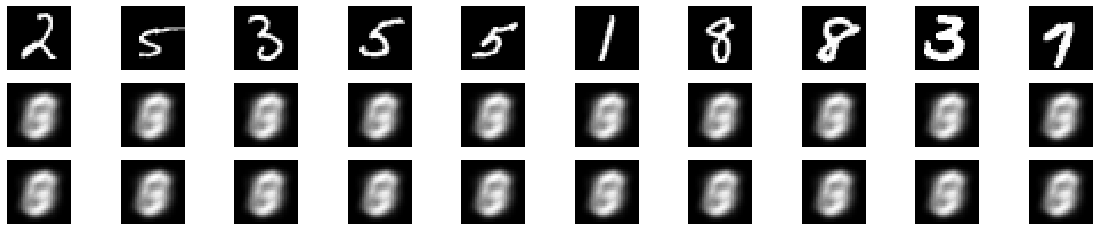

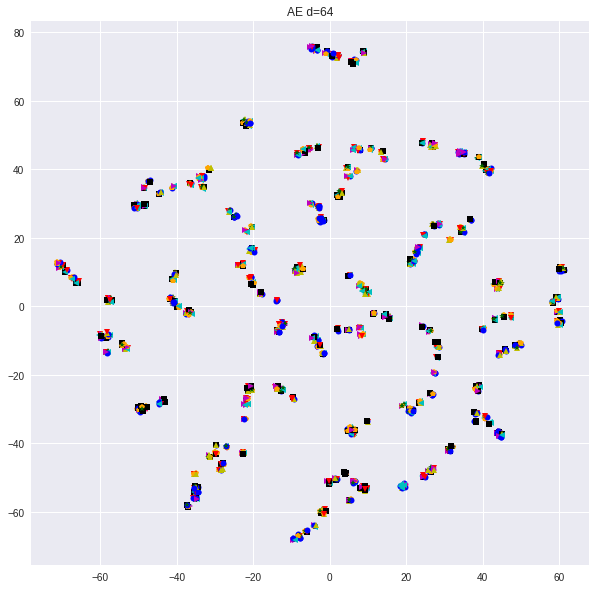

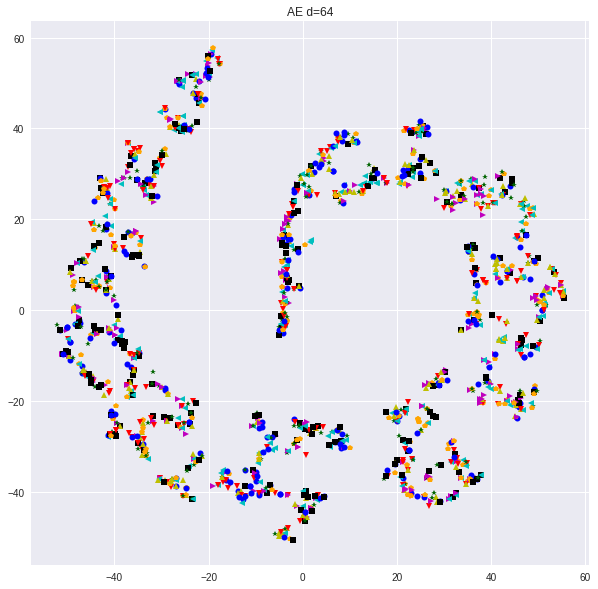

In [0]:
from sklearn.manifold import TSNE

pred = autoencoder.predict(data)
pred_sim = autoencoder.predict(data_sim)

# Visualizate prediction
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    j = np.random.randint(0,len(data))
    # original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(data[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
      
    # image with noise
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(pred[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # image with noise
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(pred_sim[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
      
plt.show()

# Visualizate with TSNE

#embeddings = encoder.predict(data) #project this with TSNE
nplot=2000 
#input_img = Input(shape=(784,))
#encoded_input = Input(shape=(input_img,))
embeddings = encoder.predict(data[:nplot])
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(embeddings)


plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
plt.title("AE d=64")
for idx in range(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
plt.show()


# data_sim
embeddings = encoder.predict(data_sim[:nplot])
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(embeddings)


plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
plt.title("AE d=64")
for idx in range(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
plt.show()


## Pre-training 

In [0]:
from keras.utils import to_categorical
from keras.models import Sequential

print(y_train.shape,y_test.shape,y_val.shape)

Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)
Y_val = to_categorical(y_val,10)

print(Y_train.shape,Y_test.shape,Y_val.shape)

print(x_train.shape)
print(x_val.shape)

model = Sequential()
model.add(Dense(1000, activation='sigmoid', input_shape=(784,)))
model.add(Dense(1000, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))
model.summary()
optimizer_ = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train,nb_epoch=50, batch_size=25,shuffle=True, validation_data=(x_val, Y_val))
model.save('ReluNet-768x1000x1000x10-NFT-50epochs.h5')

(55000,) (10000,) (5000, 28, 28)
(55000, 10) (10000, 10) (5000, 28, 28, 10)
(55000, 784)
(5000, 784)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_143 (Dense)            (None, 1000)              785000    
_________________________________________________________________
dense_144 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_145 (Dense)            (None, 10)                10010     
Total params: 1,796,010
Trainable params: 1,796,010
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


ValueError: ignored

In [0]:
score = model.evaluate(x_test, Y_test, batch_size=64)

### Deep AE (pre-training)

#### FF

In [0]:
from keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = mnist.load_data()
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)
x_train = x_train.reshape((x_train.shape[0],x_train[0].size))
x_test = x_test.reshape((x_test.shape[0],x_test[0].size))
from keras.models import Sequential
model = Sequential()
model.add(Dense(1000, activation='sigmoid', input_shape=(784,)))
model.add(Dense(1000, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))
model.summary()
optimizer_ = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train,nb_epoch=50, batch_size=25,shuffle=True)
model.save('ReluNet-768x1000x1000x10-NFT-50epochs.h5')
scores = model.evaluate(x_test, Y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dense_48 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_49 (Dense)             (None, 10)                10010     
Total params: 1,796,010
Trainable params: 1,796,010
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Epoch 1/50
60000/60000 [==============================] - 44s 736us/step - loss: 0.5677 - acc: 0.8277
Epoch 2/50
60000/60000 [==============================] - 44s 726us/step - loss: 0.5322 - acc: 0.8320
Epoch 3/50
60000/60000 [==============================] - 43s 713us/step - loss: 0.5218 - acc: 0.8349
Epoch 4/50
60000/60000 [==============================] - 43s 713us/step - loss: 0.4892 - acc: 0.8450
Epoch 5/50
60000/60000 [==============================] - 43s 709us/step - loss: 0.4677 - acc: 0.8526
Epoch 6/50
60000/60000 [==============================] - 44s 727us/step - loss: 0.4874 - acc: 0.8447
Epoch 7/50
60000/60000 [==============================] - 43s 723us/step - loss: 0.4735 - acc: 0.8502
Epoch 8/50
60000/60000 [==============================] - 44s 728us/step - loss: 0.4502 - acc: 0.8580
Epoch 9/50
60000/60000 [==============================] - 44s 738us/step - loss: 0.4261 - acc: 0.8656
Epoch 10/50
60000/60000 [==============================] - 43s 720us/step - loss: 

### Deep network with sigmoid

In [0]:
from keras.datasets import mnist

## Load and preprocess MNIST as usual
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Normalize data
x_train = x_train.astype('float32') / 255. 
x_test = x_test.astype('float32') / 255. 
x_val  = x_train[:5000]
y_val = x_train[:5000]
x_train = x_train[5000:]
y_train = y_train[5000:]
print(x_train.shape,x_val.shape,x_test.shape)
# Convert to vector
x_train = x_train.reshape((x_train.shape[0],x_train[0].size))
x_test = x_test.reshape((x_test.shape[0],x_test[0].size))
x_val = x_val.reshape((x_val.shape[0],x_val[0].size))

# Parameters 
n_hidden_layer1 = 64
activation_layer1 = "sigmoid"
decoder_activation_1 = "sigmoid"

n_hidden_layer2 = 64
activation_layer2 = "sigmoid"
decoder_activation_2 = "sigmoid"

optimizer_ = SGD(lr=1.0)
loss_ = 'binary_crossentropy'
epochs_ = 20
batch_size_ = 64



###AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1,activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(inputs=input_img1, outputs=decoded1)
encoder1 = Model(inputs=input_img1, outputs=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(x_train, x_train, nb_epoch=epochs_, batch_size=batch_size_,shuffle=True, validation_data=(x_val, x_val))
encoded_input1 = Input(shape=(n_hidden_layer1,))
autoencoder1.save('autoencoder_layer1.h5')
encoder1.save('encoder_layer1.h5')


###AUTOENCODER 2
x_train_encoded1 = encoder1.predict(x_train) #FORWARD PASS DATA THROUGH FIRST ENCODER
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)
input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer2, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(inputs=input_img2, outputs=decoded2)
encoder2 = Model(inputs=input_img2, outputs=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(x_train_encoded1,x_train_encoded1,nb_epoch=epochs_,batch_size=batch_size_,shuffle=True, validation_data=(x_val_encoded1, x_val_encoded1))
encoded_input2 = Input(shape=(n_hidden_layer2,))
autoencoder2.save('autoencoder_layer2.h5')
encoder2.save('encoder_layer2.h5')


#FINE TUNNING
from keras.models import Sequential

model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.layers[-1].set_weights(autoencoder2.layers[1].get_weights())
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer=optimizer_,loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train,nb_epoch=20, batch_size=25,
shuffle=True, validation_data=(x_val, Y_val))
model.save('Net-768x1000x1000x10-finetunned.h5')

(55000, 28, 28) (5000, 28, 28) (10000, 28, 28)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 7s 126us/step - loss: 0.3125 - val_loss: 0.2690
Epoch 2/20
55000/55000 [==============================] - 5s 96us/step - loss: 0.2669 - val_loss: 0.2655
Epoch 3/20
55000/55000 [==============================] - 5s 97us/step - loss: 0.2650 - val_loss: 0.2645
Epoch 4/20
55000/55000 [==============================] - 5s 95us/step - loss: 0.2641 - val_loss: 0.2636
Epoch 5/20
55000/55000 [==============================] - 5s 96us/step - loss: 0.2630 - val_loss: 0.2622
Epoch 6/20
55000/55000 [==============================] - 5s 95us/step - loss: 0.2609 - val_loss: 0.2593
Epoch 7/20
55000/55000 [==============================] - 5s 96us/step - loss: 0.2575 - val_loss: 0.2554
Epoch 8/20
55000/55000 [==============================] - 5s 96us/step - loss: 0.2536 - val_loss: 0.2515
Epoch 9/20
55000/55000 [==============================] - 5s 95us/step - loss: 0.2498 - val_loss: 0.2479
Epoch

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 3s 53us/step - loss: 0.2505 - val_loss: 0.2233
Epoch 2/20
55000/55000 [==============================] - 2s 27us/step - loss: 0.1980 - val_loss: 0.1789
Epoch 3/20
55000/55000 [==============================] - 2s 27us/step - loss: 0.1708 - val_loss: 0.1640
Epoch 4/20
55000/55000 [==============================] - 2s 27us/step - loss: 0.1614 - val_loss: 0.1579
Epoch 5/20
55000/55000 [==============================] - 2s 28us/step - loss: 0.1572 - val_loss: 0.1550
Epoch 6/20
55000/55000 [==============================] - 2s 28us/step - loss: 0.1552 - val_loss: 0.1534
Epoch 7/20
55000/55000 [==============================] - 2s 27us/step - loss: 0.1539 - val_loss: 0.1523
Epoch 8/20
55000/55000 [==============================] - 2s 28us/step - loss: 0.1528 - val_loss: 0.1514
Epoch 9/20
55000/55000 [==============================] - 2s 27us/step - loss: 0.1519 - val_loss: 0.1505
Epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


ValueError: ignored

<a id="refs"></a>
## Referencias
[1] George Kingsley Zipf (1949), *Human behavior and the principle of least effort*, Addison-Wesley Press  
[2] https://www.nvidia.es/object/cuda-parallel-computing-es.html  
[3] http://yann.lecun.com/exdb/mnist/  
[4] Vincent, P., Larochelle, H., Bengio, Y., & Manzagol, P. A. (2008, July). *Extracting and composing robust features with denoising autoencoders*. ACM.